# TFRecords制作

为了高效的读取数据，可以将数据进行序列化存储，这样也便于网络流式读取数据，TFRecord是一种比较常用的存错二进制序列的方法

tf.Example类是一种将数据表示为("string": value)形式的message类型，Tensorflow经常使用tf.Example来写入，读取TFRecord数据

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf

# 通常情况下，tf.Example中可以使用以下几种格式:
tf.train.BytesList  可以使用的类型包括 string和byte \
tf.train.FloatList  可以使用的类型包括 float和double \
tf.train.Int64List  可以使用的类型包括 enum,bool,int32,uint32,int64

In [2]:
# 转化实例
def _bytes_feature(value):
    # return a bytes_list from a string/byte
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()    # bytelist won't unpack a sting from an EagerTensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    # return a float_list from a float/double
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    # return a int64_list from a enum/bool/int32/uint32/int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [3]:
# tf.train.ByteList
print(_bytes_feature(b"test_string"))
print(_bytes_feature("test_string".encode("utf-8")))

# tf.train.FloatList
print(_float_feature(np.exp(1)))

# tf.train.Int64List
print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_string"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



# TFRecord制作方法

创建tf.Example

In [4]:
def serialize_example(feature0, feature1, feature2, feature3):
    # 创建tf.Example
    
    # 转换成相应类型
    feature = {
        "feature0": _int64_feature(feature0),
        "feature1": _int64_feature(feature1),
        "feature2": _bytes_feature(feature2),
        "feature3": _float_feature(feature3)
    }
    
    # 使用tf.train.Example来创建
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    # SerializeToString方法转换二进制字符串
    return example_proto.SerializeToString()

In [5]:
# 数据量
n_observations = int(1e4)

# Boolean feature 
feature0 = np.random.choice([False, True], n_observations)

# Interger feature
feature1 = np.random.randint(0, 5, n_observations)

# String feature
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# Float feature
feature3 = np.random.randn(n_observations)

In [6]:
filename = 'tfrecord-1'

with tf.io.TFRecordWriter(filename) as writer:
    for i in range(n_observations):
        example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
        writer.write(example)

# 加载tfrecord文件

In [7]:
filenames = [filename]

# 读取
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

# 图形数据处理实例

In [8]:
import os
import glob
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mping
%matplotlib inline

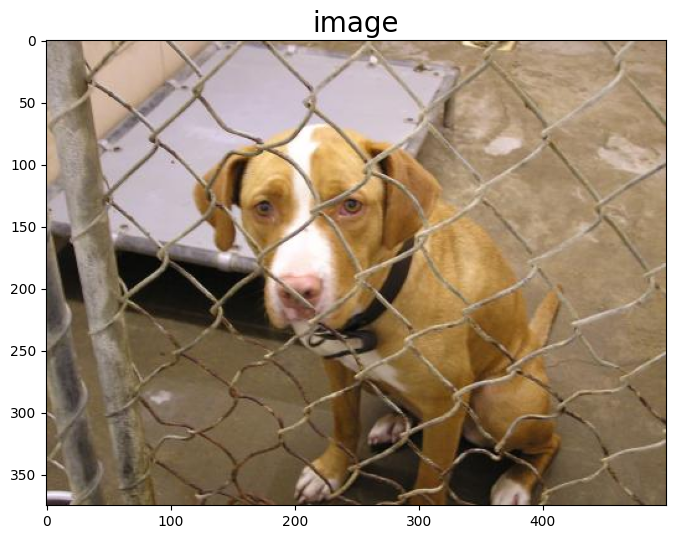

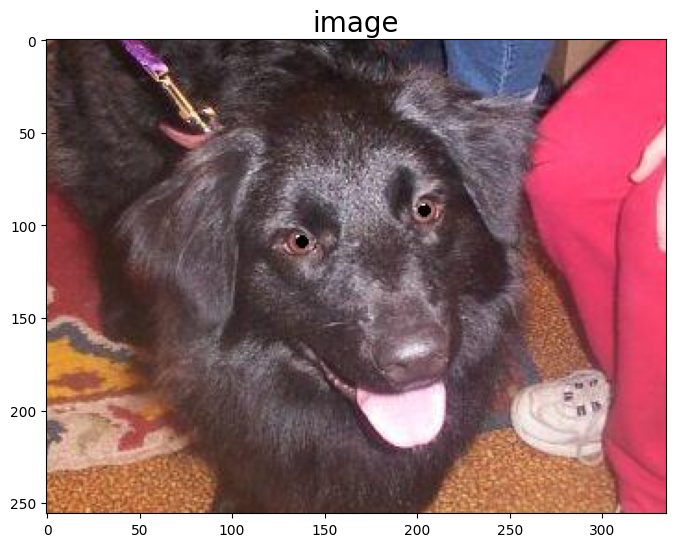

In [9]:
image_path = "./data/PetImages/testing/dogs/"
images = glob.glob(image_path + '*.jpg')

for fname in images[:2]:
    image = mping.imread(fname)
    f, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
    f.subplots_adjust(hspace=.2, wspace=0.5)
    
    ax1.imshow(image)
    ax1.set_title("image", fontsize=20)

In [10]:
image_lables = {
    'dog': 0,
    'cat': 1
}

# 制作TFRecord

In [11]:
# 读取数据,binary格式
image_string = open('./data/PetImages/Dog/2.jpg', 'rb').read()
label = image_lables['dog']

In [12]:
# 创建图形数据的Example
def image_example(image_string, label):
    image_shape = tf.image.decode_jpeg(image_string).shape
#     image_shape = tf.image.decode_image(image_string).shape
    
    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string)
    }
    
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [13]:
# 打印部分信息
image_example_proto = image_example(image_string, label)

for line in str(image_example_proto).split("\n")[:15]:
    print(line)
print("...")

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 199
      }
...


In [14]:
from tensorflow.python.framework.errors import InvalidArgumentError

In [15]:
# 制作 images.tfrecords

image_path = "./data/PetImages/training/dogs/"
images = glob.glob(image_path + "*.jpg")
image_path2 = "./data/PetImages/training/cats/"
images2 = glob.glob(image_path2 + "*.jpg")
record_file = 'images.tfrecord'
counter = 0

with tf.io.TFRecordWriter(record_file) as writer:
    for fname in images:
        with open(fname, 'rb') as f:
            image_string = f.read()
            label = image_lables['dog']
            
            # tf.Example
            try:
                tf_example = image_example(image_string, label)
            except InvalidArgumentError:
                continue
            
            writer.write(tf_example.SerializeToString())
            
            counter += 1
            if counter % 1000 == 0:
                print('Processed dogs {:d} of {:d} images.'.format(counter, len(images)))
                
    for fname in images2:
        with open(fname, 'rb') as f:
            image_string = f.read()
            label = image_lables['cat']
            
            # tf.Example
            try:
                tf_example = image_example(image_string, label)
            except InvalidArgumentError:
                continue
            
            writer.write(tf_example.SerializeToString())
            
            counter += 1
            if counter % 1000 == 0:
                print('Processed cats {:d} of {:d} images.'.format(counter, len(images2)+len(images)))

print("wrote {} images to {}".format(counter, record_file))

Processed dogs 1000 of 11249 images.
Processed dogs 2000 of 11249 images.
Processed dogs 3000 of 11249 images.
Processed dogs 4000 of 11249 images.
Processed dogs 5000 of 11249 images.
Processed dogs 6000 of 11249 images.
Processed dogs 7000 of 11249 images.
Processed dogs 8000 of 11249 images.
Processed dogs 9000 of 11249 images.
Processed dogs 10000 of 11249 images.
Processed dogs 11000 of 11249 images.
Processed cats 12000 of 22498 images.
Processed cats 13000 of 22498 images.
Processed cats 14000 of 22498 images.
Processed cats 15000 of 22498 images.
Processed cats 16000 of 22498 images.
Processed cats 17000 of 22498 images.
Processed cats 18000 of 22498 images.
Processed cats 19000 of 22498 images.
Processed cats 20000 of 22498 images.
Processed cats 21000 of 22498 images.
Processed cats 22000 of 22498 images.
wrote 22339 images to images.tfrecord


In [16]:
os.path.basename(fname)

'9999.jpg'

# 加载制作好的TFRecord

In [17]:
raw_train_dataset = tf.data.TFRecordDataset('./images.tfrecord')
raw_train_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

example数据都进行了序列化，还需要解析以下之前写入的序列化string

tf.io.parse_single_example(example_proto, feature_description)函数可以解析单条example

In [18]:
# 解析的格式需要跟之前创建example时一致
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string)
}

使用map函数来映射整个样本

In [19]:
def parse_tf_example(example_proto):
    # 解析出来
    parsed_example = tf.io.parse_single_example(example_proto, image_feature_description)
    
    # 预处理
    x_train = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)
    x_train = tf.image.resize(x_train, (256, 256))
    x_train /= 255.
    
    label = parsed_example['label']
    y_train = label
    
    return x_train, y_train

train_dataset =  raw_train_dataset.map(parse_tf_example)
train_dataset

<MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

# 制作训练集

In [20]:
num_epochs = 10

# train_ds =  train_dataset.shuffle(buffer_size=22500).batch(128).repeat(num_epochs)
train_ds =  train_dataset.shuffle(buffer_size=22500).batch(100)
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [21]:
for batch, (x, y) in enumerate(train_ds):
    print(batch, x.shape, y)
    break

0 (100, 256, 256, 3) tf.Tensor(
[1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0
 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 0 0 1 1], shape=(100,), dtype=int64)


In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['acc']
             )

# model.compile(optimizer='adam',
#               loss="binary_crossentropy",  # dense得设为1
#               metrics=['acc']
#              )

制作 test.tfrecords

In [25]:
image_path = "./data/PetImages/testing/dogs/"
images = glob.glob(image_path + "*.jpg")
image_path2 = "./data/PetImages/testing/cats/"
images2 = glob.glob(image_path2 + "*.jpg")
record_file = 'test.tfrecord'
counter = 0

with tf.io.TFRecordWriter(record_file) as writer:
    for fname in images:
        with open(fname, 'rb') as f:
            image_string = f.read()
            label = image_lables['dog']
            
            # tf.Example
            try:
                tf_example = image_example(image_string, label)
            except InvalidArgumentError:
                continue
            
            writer.write(tf_example.SerializeToString())
            
            counter += 1
            if counter % 1000 == 0:
                print('Processed dogs {:d} of {:d} images.'.format(counter, len(images)))
                
    for fname in images2:
        with open(fname, 'rb') as f:
            image_string = f.read()
            label = image_lables['cat']
            
            # tf.Example
            try:
                tf_example = image_example(image_string, label)
            except InvalidArgumentError:
                continue
            
            writer.write(tf_example.SerializeToString())
            
            counter += 1
            if counter % 1000 == 0:
                print('Processed cats {:d} of {:d} images.'.format(counter, len(images2)+len(images)))

print("wrote {} images to {}".format(counter, record_file))

# 加载测试集
raw_test_dataset = tf.data.TFRecordDataset('./test.tfrecord')
test_dataset =  raw_test_dataset.map(parse_tf_example)
test_ds =  test_dataset.shuffle(buffer_size=5000).batch(100)

Processed dogs 1000 of 1250 images.
Processed cats 2000 of 2500 images.
wrote 2485 images to test.tfrecord


图片的尺寸、网络的参数、每个batch都不能太大，太耗内存\
可以把数据集多存成几个tfrecord

In [ ]:
model.fit(train_ds, epochs=20)

Epoch 1/20
224/224 [==============================] - 1015s 4s/step - loss: 0.7204 - acc: 0.5943
Epoch 2/20
224/224 [==============================] - 1262s 5s/step - loss: 0.5477 - acc: 0.7230
Epoch 3/20
224/224 [==============================] - 1487s 6s/step - loss: 0.4885 - acc: 0.7657
Epoch 4/20
224/224 [==============================] - 1541s 7s/step - loss: 0.4323 - acc: 0.7974
Epoch 5/20
224/224 [==============================] - 1721s 8s/step - loss: 0.3731 - acc: 0.8340
Epoch 6/20
224/224 [==============================] - 1839s 8s/step - loss: 0.3279 - acc: 0.8586
Epoch 7/20
224/224 [==============================] - 1875s 8s/step - loss: 0.2884 - acc: 0.8743
Epoch 8/20
224/224 [==============================] - 2033s 9s/step - loss: 0.2416 - acc: 0.8993
Epoch 9/20
224/224 [==============================] - 2072s 9s/step - loss: 0.2079 - acc: 0.9149
Epoch 10/20
 99/224 [============>.................] - ETA: 27:15 - loss: 0.1628 - acc: 0.9361

In [ ]:
model.evaluate(test_ds)